In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import precision_score, confusion_matrix

In [527]:
df = pd.read_csv('dataset/stocknet-dataset-master/price/raw/GOOG.csv')

<Axes: >

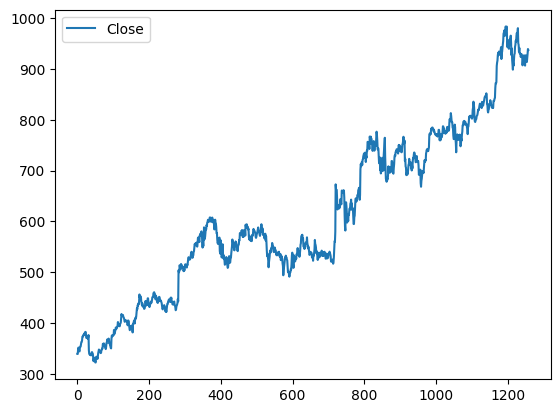

In [529]:
df.plot.line(y='Close')

In [530]:
del df['Adj Close']

In [531]:
df

,Date,Open,High,Low,Close,Volume
0,2012-09-04,340.996857,341.221008,335.492493,339.248413,3793200
1,2012-09-05,338.730347,341.968231,338.301971,339.089020,3429100
2,2012-09-06,341.699219,348.638214,341.086517,348.394135,6109700
3,2012-09-07,348.693024,354.795135,347.532349,351.756531,6490100
4,2012-09-10,353.554779,355.074097,347.891022,349.076569,5139100
...,...,...,...,...,...,...
1253,2017-08-28,916.000000,919.244995,911.869995,913.809998,1086500
1254,2017-08-29,905.099976,923.330017,905.000000,921.289978,1185600
1255,2017-08-30,920.049988,930.818970,919.650024,929.570007,1301200
1256,2017-08-31,931.760010,941.979980,931.760010,939.330017,1582600


In [532]:
df['Tomorrow'] = df['Close'].shift(-1)

In [533]:
df

,Date,Open,High,Low,Close,Volume,Tomorrow
0,2012-09-04,340.996857,341.221008,335.492493,339.248413,3793200,339.089020
1,2012-09-05,338.730347,341.968231,338.301971,339.089020,3429100,348.394135
2,2012-09-06,341.699219,348.638214,341.086517,348.394135,6109700,351.756531
3,2012-09-07,348.693024,354.795135,347.532349,351.756531,6490100,349.076569
4,2012-09-10,353.554779,355.074097,347.891022,349.076569,5139100,344.802582
...,...,...,...,...,...,...,...
1253,2017-08-28,916.000000,919.244995,911.869995,913.809998,1086500,921.289978
1254,2017-08-29,905.099976,923.330017,905.000000,921.289978,1185600,929.570007
1255,2017-08-30,920.049988,930.818970,919.650024,929.570007,1301200,939.330017
1256,2017-08-31,931.760010,941.979980,931.760010,939.330017,1582600,937.340027


In [534]:
df['Target'] = (df['Close'] < df['Tomorrow']).astype(int)

In [535]:
df

,Date,Open,High,Low,Close,Volume,Tomorrow,Target
0,2012-09-04,340.996857,341.221008,335.492493,339.248413,3793200,339.089020,0
1,2012-09-05,338.730347,341.968231,338.301971,339.089020,3429100,348.394135,1
2,2012-09-06,341.699219,348.638214,341.086517,348.394135,6109700,351.756531,1
3,2012-09-07,348.693024,354.795135,347.532349,351.756531,6490100,349.076569,0
4,2012-09-10,353.554779,355.074097,347.891022,349.076569,5139100,344.802582,0
...,...,...,...,...,...,...,...,...
1253,2017-08-28,916.000000,919.244995,911.869995,913.809998,1086500,921.289978,1
1254,2017-08-29,905.099976,923.330017,905.000000,921.289978,1185600,929.570007,1
1255,2017-08-30,920.049988,930.818970,919.650024,929.570007,1301200,939.330017,1
1256,2017-08-31,931.760010,941.979980,931.760010,939.330017,1582600,937.340027,0


In [536]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=50, random_state=1)

train = df.iloc[:-100]
test = df.iloc[-100:]

features = ['Open', 'Close', 'High', 'Low', 'Volume']
model.fit(train[features], train['Target'])

RandomForestClassifier(min_samples_split=50, n_estimators=1000, random_state=1)

In [537]:
predictions = model.predict(test[features])
predictions = pd.Series(predictions, index=test.index)

In [538]:
precision_score(test['Target'], predictions)

0.5

In [539]:
combined = pd.concat([test['Target'], predictions], axis=1)

<Axes: >

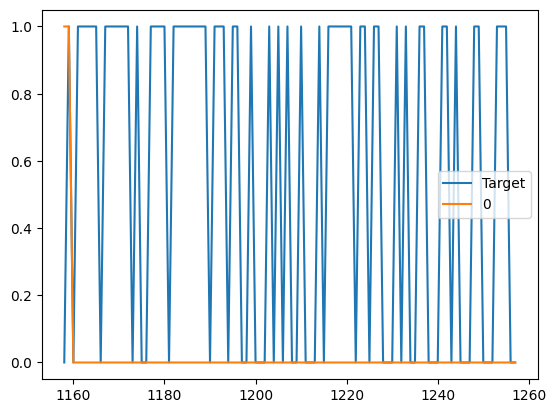

In [540]:
combined.plot()

In [541]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    predictions = model.predict(test[predictors])
    predictions = pd.Series(predictions, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], predictions], axis=1)
    return combined

In [542]:
def backtest(data, model, predictors, start=250, step=25):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [543]:
predictions = backtest(df, model, features)

In [544]:
predictions['Predictions'].value_counts()

0    603
1    405
Name: Predictions, dtype: int64

In [545]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5358024691358024

In [546]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.519841
0    0.480159
Name: Target, dtype: float64

# Feedforward Neural Network

In [547]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

features = ['Open', 'Close', 'High', 'Low', 'Volume']
X_train = train[features]
y_train = train['Target']
X_test = test[features]
y_test = test['Target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [548]:
from tensorflow.keras.initializers import HeNormal

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer=HeNormal()), 
    Dropout(0.5),
    Dense(32, activation='relu', kernel_initializer=HeNormal()), 
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_initializer=HeNormal())  
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test)
)

Epoch 1/50
37/37 [==============================] - 1s 7ms/step - loss: 1.1955 - accuracy: 0.4801 - val_loss: 0.7814 - val_accuracy: 0.5800
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.9149 - accuracy: 0.5043 - val_loss: 0.7437 - val_accuracy: 0.5800
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.8980 - accuracy: 0.5095 - val_loss: 0.7245 - val_accuracy: 0.5800
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.8314 - accuracy: 0.4940 - val_loss: 0.7062 - val_accuracy: 0.5800
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7886 - accuracy: 0.5035 - val_loss: 0.7161 - val_accuracy: 0.5800
Epoch 6/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7885 - accuracy: 0.4896 - val_loss: 0.7112 - val_accuracy: 0.5800
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.7688 - accuracy: 0.4784 - val_loss: 0.6918 - val_accuracy: 0.5800
Epoch 8/50
37/37 [==

In [549]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_prob_sd = np.std(y_pred_prob)
y_pred = (y_pred_prob > (0.50 + y_prob_sd)).astype(int)

4/4 [==============================] - 0s 1ms/step - loss: 0.6848 - accuracy: 0.5900
Test Accuracy: 0.59
4/4 [==============================] - 0s 953us/step


In [550]:
precision_score(test['Target'], y_pred)

0.5869565217391305

In [551]:
confusion_matrix(test['Target'], y_pred)

array([[ 4, 38],
       [ 4, 54]])

In [552]:
len(y_pred)

100

In [553]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    predictions = model.predict(test[predictors])
    predictions = predictions.flatten()
    predictions = pd.Series(predictions, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], predictions], axis=1)
    return combined

In [554]:
y_pred_prob = backtest(df, model, features)
y_prob_sd = np.std(y_pred_prob['Predictions'])
y_pred = (y_pred_prob['Predictions'] > (0.5)).astype(int)

1/1 [==============================] - 0s 19ms/step


In [555]:
precision_score(y_pred_prob['Target'], y_pred)

0.5198329853862212

In [556]:
confusion_matrix(y_pred_prob['Target'], y_pred)

array([[ 24, 460],
       [ 26, 498]])

# Rolling means to improve performance

In [557]:
intervals = [2, 5, 20, 60, 250]
new_features = []

for interval in intervals:
    rolling_means = df.rolling(interval).mean()
    ratio_column = f"CLose_Ratio_{interval}"
    df[ratio_column] = df['Close'] / rolling_means['Close']

    trend_column = f"Trend_{interval}"
    df[trend_column] = df.shift(1).rolling(interval).sum()['Target']

    new_features += [ratio_column, trend_column]

/tmp/ipykernel_149/3399931599.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolling_means = df.rolling(interval).mean()
/tmp/ipykernel_149/3399931599.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  df[trend_column] = df.shift(1).rolling(interval).sum()['Target']
/tmp/ipykernel_149/3399931599.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolling_means = df.rolling(interval).mean()
/tmp/ipykernel_149/33

In [558]:
df = df.dropna()

In [560]:
model = Sequential([
    Dense(64, activation='relu', input_dim=len(new_features), kernel_initializer=HeNormal()), 
    Dropout(0.5),
    Dense(32, activation='relu', kernel_initializer=HeNormal()), 
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_initializer=HeNormal())  
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [561]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'], epochs=10)
    predictions = model.predict(test[predictors])
    predictions = predictions.flatten()
    predictions = pd.Series(predictions, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], predictions], axis=1)
    return combined

In [562]:
y_pred_prob = backtest(df, model, new_features)
y_prob_sd = np.std(y_pred_prob['Predictions'])
y_pred = (y_pred_prob['Predictions'] > (0.51)).astype(int)

Epoch 1/10
8/8 [==============================] - 1s 3ms/step - loss: 62.6902 - accuracy: 0.4920
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 44.2204 - accuracy: 0.4800
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 35.4244 - accuracy: 0.5280
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 30.1165 - accuracy: 0.5320
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 28.5804 - accuracy: 0.5560
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 25.3959 - accuracy: 0.5280
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 30.4305 - accuracy: 0.4360
Epoch 8/10
8/8 [==============================] - 0s 4ms/step - loss: 24.5035 - accuracy: 0.5000
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 20.2098 - accuracy: 0.5240
Epoch 10/10
1/1 [==============================] - 0s 40ms/step
Epoch 1/10
9/9 [==============================] - 0s 2ms/step -

In [563]:
precision_score(y_pred_prob['Target'], y_pred)

0.5757575757575758

In [564]:
confusion_matrix(y_pred_prob['Target'], y_pred)

array([[300,  56],
       [325,  76]])

# Sentiment Analysis
Sentiment analysis based on tweets is added to the rolling means dataset

In [565]:
df_sentiment=pd.read_csv('sentiment/stock_data.csv')

In [566]:
def clean_text(Text):
    import re
    Text = re.sub(r'http\S+|www\S+|https\S+', '', Text, flags=re.MULTILINE)
    Text = re.sub(r'\@w+|\#', '', Text)
    Text = re.sub(r'\d+', '', Text)

    Text = Text.lower()
    
    from nltk.corpus import stopwords
    Text = ' '.join(word for word in Text.split())
    return Text

df_sentiment['Text'] = df_sentiment['Text'].apply(clean_text)

In [567]:
df_sentiment['Text'] = df_sentiment['Text'].fillna('').astype(str)
df_sentiment['Text'] = df_sentiment['Text'].apply(clean_text)

In [568]:
from sklearn.model_selection import train_test_split as tts
x_train,x_test,y_train,y_test=tts(df_sentiment['Text'],df_sentiment['Sentiment'],test_size=0.2,random_state=42)

In [569]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x_train_tf = vectorizer.fit_transform(x_train)
x_test_tf = vectorizer.transform(x_test)

In [570]:
import pandas as pd
import json
from pandas import json_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

vectorizer = TfidfVectorizer()
x_train_tf = vectorizer.fit_transform(x_train)

x_train_tf, x_val_tf, y_train, y_val = train_test_split(x_train_tf, y_train, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_dim=x_train_tf.shape[1]),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='tanh')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

x_train_tf_dense = x_train_tf.toarray()
x_val_tf_dense = x_val_tf.toarray()

model.fit(x_train_tf_dense, y_train, epochs=50, batch_size=32, validation_data=(x_val_tf_dense, y_val))

Epoch 1/50
116/116 [==============================] - 1s 3ms/step - loss: 0.8628 - mae: 0.8831 - val_loss: 0.7173 - val_mae: 0.7944
Epoch 2/50
116/116 [==============================] - 0s 3ms/step - loss: 0.4503 - mae: 0.5116 - val_loss: 0.6172 - val_mae: 0.5632
Epoch 3/50
116/116 [==============================] - 0s 3ms/step - loss: 0.2061 - mae: 0.2618 - val_loss: 0.6501 - val_mae: 0.5303
Epoch 4/50
116/116 [==============================] - 0s 4ms/step - loss: 0.0960 - mae: 0.1459 - val_loss: 0.6841 - val_mae: 0.5128
Epoch 5/50
116/116 [==============================] - 0s 3ms/step - loss: 0.0563 - mae: 0.0917 - val_loss: 0.7274 - val_mae: 0.5252
Epoch 6/50
116/116 [==============================] - 0s 2ms/step - loss: 0.0336 - mae: 0.0626 - val_loss: 0.7230 - val_mae: 0.5052
Epoch 7/50
116/116 [==============================] - 0s 3ms/step - loss: 0.0208 - mae: 0.0437 - val_loss: 0.7355 - val_mae: 0.5030
Epoch 8/50
116/116 [==============================] - 0s 3ms/step - loss: 0.

In [571]:
import os
import json
import pandas as pd
from pandas import json_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime

def clean_text(text):
    return text.lower()

folder_path = 'dataset/stocknet-dataset-master/tweet/raw/GOOG/'

results = []

start_date = datetime(2014, 1, 1)
end_date = datetime(2016, 12, 31)
all_dates = pd.date_range(start=start_date, end=end_date).to_frame(index=False, name='date')

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    try:
        file_date = datetime.strptime(filename.split('.')[0], '%Y-%m-%d').date()
    except ValueError:
        print(f"Skipping invalid filename: {filename}")
        continue

    try:
        df_tweet = pd.read_csv(file_path, delimiter='\t', header=None, names=['json_content'])
        df_tweet['parsed'] = df_tweet['json_content'].apply(json.loads)
        df_normalized = json_normalize(df_tweet['parsed'])

        df_normalized['text'] = df_normalized['text'].apply(clean_text)
        df_normalized['text'] = df_normalized['text'].fillna('').astype(str)

        df_tf = vectorizer.transform(df_normalized['text'])

        df_tf_dense = df_tf.toarray()  # Convert to dense NumPy array

        y_pred = model.predict(df_tf_dense)
        y_pred_label = ((sum(y_pred > 0).astype(int) / len(y_pred)) - 0.5) * 2

        results.append({'date': file_date, 'sentiment_label': y_pred_label})

    except Exception as e:
        print(f"Error processing {filename}: {e}")

results_df = pd.DataFrame(results)

results_df['date'] = pd.to_datetime(results_df['date'])
merged_df = pd.merge(all_dates, results_df, on='date', how='left')

merged_df['sentiment_label'] = merged_df['sentiment_label'].fillna(0)

merged_df = merged_df.sort_values(by='date').reset_index(drop=True)

print(merged_df)

1/1 [==============================] - 0s 22ms/step
           date       sentiment_label
0    2014-01-01  [0.7142857142857142]
1    2014-01-02                 [1.0]
2    2014-01-03  [0.7142857142857142]
3    2014-01-04                [-1.0]
4    2014-01-05                 [1.0]
...         ...                   ...
1091 2016-12-27                     0
1092 2016-12-28                     0
1093 2016-12-29                     0
1094 2016-12-30                     0
1095 2016-12-31                     0

[1096 rows x 2 columns]


In [582]:
df['Date'] = pd.to_datetime(df['Date'])
merged_df['date'] = pd.to_datetime(merged_df['date'])

df = pd.merge(df, merged_df[['date', 'sentiment_label']], left_on='Date', right_on='date', how='left')

df = df.drop(columns=['date'])

df['sentiment_label'] = df['sentiment_label'].fillna(0)

KeyError: 'sentiment_label'

In [601]:
df = df.drop(columns=['sentiment_label_y'])

df.rename(columns={'sentiment_label_x': 'sentiment_label'}, inplace=True)

df['sentiment_label'] = df['sentiment_label'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)

In [606]:
model = Sequential([
    Dense(64, activation='relu', input_dim=len(new_features), kernel_initializer=HeNormal()), 
    Dropout(0.5),
    Dense(32, activation='relu', kernel_initializer=HeNormal()), 
    Dropout(0.5),
    Dense(1, activation='sigmoid', kernel_initializer=HeNormal())  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [607]:
y_pred_prob = backtest(df, model, new_features)
y_prob_sd = np.std(y_pred_prob['Predictions'])
y_pred = (y_pred_prob['Predictions'] > (0.51)).astype(int)

Epoch 1/10
8/8 [==============================] - 1s 3ms/step - loss: 27.3226 - accuracy: 0.5240
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 28.0613 - accuracy: 0.4960
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 23.6166 - accuracy: 0.4960
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 24.1948 - accuracy: 0.4720
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 23.1773 - accuracy: 0.4680
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 20.5775 - accuracy: 0.5200
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 19.0532 - accuracy: 0.4960
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 16.1059 - accuracy: 0.5000
Epoch 9/10
8/8 [==============================] - 0s 4ms/step - loss: 11.0608 - accuracy: 0.5400
Epoch 10/10
1/1 [==============================] - 0s 44ms/step
Epoch 1/10
9/9 [==============================] - 0s 2ms/step -

In [608]:
precision_score(y_pred_prob['Target'], y_pred)

0.5714285714285714

In [609]:
confusion_matrix(y_pred_prob['Target'], y_pred)

array([[278,  78],
       [297, 104]])

In [613]:
sum(y_pred_prob['Target']) / len(y_pred_prob['Target'])

0.5297225891677675